In [ ]:
import kagglehub
dog_skin_diseases_image_dataset_path = kagglehub.dataset_download('vekified/dog-skin-disease-v3')

print('Data source import complete.')

Data source import complete.


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


Training model...
Epoch 0/19
train Loss: 1.2361 Acc: 0.5672
valid Loss: 0.7507 Acc: 0.7523
Epoch 1/19
train Loss: 0.8081 Acc: 0.7105
valid Loss: 0.5645 Acc: 0.7907
Epoch 2/19
train Loss: 0.6687 Acc: 0.7617
valid Loss: 0.4705 Acc: 0.8349
Epoch 3/19
train Loss: 0.5978 Acc: 0.7892
valid Loss: 0.4302 Acc: 0.8477
Epoch 4/19
train Loss: 0.5313 Acc: 0.8117
valid Loss: 0.3815 Acc: 0.8663
Epoch 5/19
train Loss: 0.4595 Acc: 0.8379
valid Loss: 0.3568 Acc: 0.8802
Epoch 6/19
train Loss: 0.4248 Acc: 0.8475
valid Loss: 0.3405 Acc: 0.8826
Epoch 7/19
train Loss: 0.4126 Acc: 0.8590
valid Loss: 0.3476 Acc: 0.8907
Epoch 8/19
train Loss: 0.3644 Acc: 0.8729
valid Loss: 0.3116 Acc: 0.9058
Epoch 9/19
train Loss: 0.3576 Acc: 0.8786
valid Loss: 0.2877 Acc: 0.9081
Epoch 10/19
train Loss: 0.3057 Acc: 0.8925
valid Loss: 0.2751 Acc: 0.9279
Epoch 11/19
train Loss: 0.2739 Acc: 0.9083
valid Loss: 0.2464 Acc: 0.9233
Epoch 12/19
train Loss: 0.2811 Acc: 0.9017
valid Loss: 0.2604 Acc: 0.9174
Epoch 13/19
train Loss: 0.2434

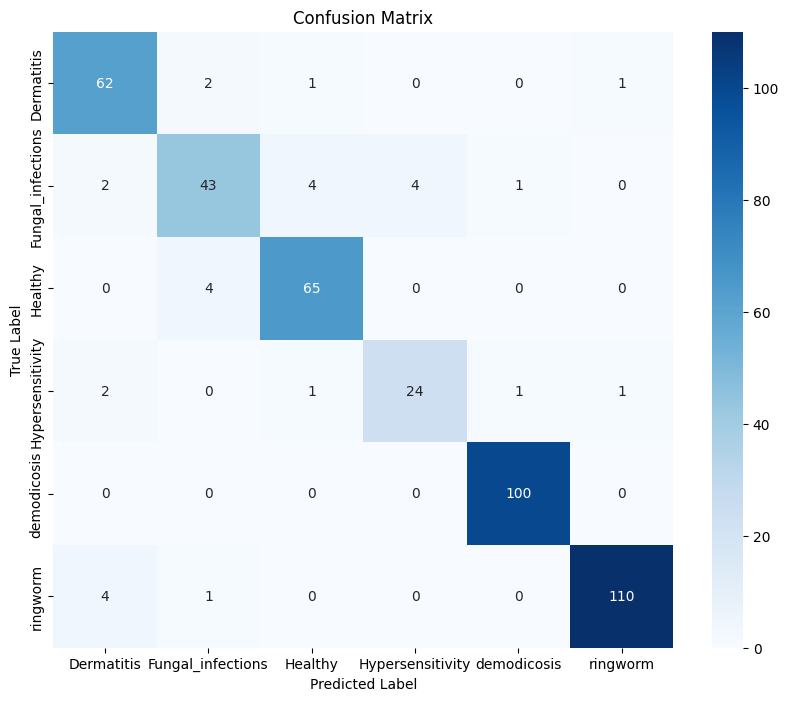

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/kaggle/input/dogs-skin-diseases-image-dataset/'
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'valid', 'test']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4)
    for x in ['train', 'valid', 'test']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes
num_classes = len(class_names)

model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

def train_model(model, criterion, optimizer, num_epochs=20):
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), 'best_model.pth')

        print('='*10)

    return model

def evaluate_model(model):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())


    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, target_names=class_names)


    tn = cm.sum(axis=1) - cm.diagonal()
    fp = cm.sum(axis=0) - cm.diagonal()
    tp = cm.diagonal()
    fn = cm.sum() - (tp + fp + tn)

    accuracy = (tp.sum()) / (tp.sum() + fp.sum() + fn.sum() + tn.sum())
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    specificity = tn / (tn + fp)
    f1 = 2 * (precision * recall) / (precision + recall)


    print('Overall Accuracy:', accuracy)
    print('Classification Report:')
    print(report)

    print('Per-class metrics:')
    for i, class_name in enumerate(class_names):
        print(f'{class_name}:')
        print(f'Precision: {precision[i]:.4f}')
        print(f'Recall: {recall[i]:.4f}')
        print(f'Specificity: {specificity[i]:.4f}')
        print(f'F1-score: {f1[i]:.4f}')
        print('='*10)


    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

if __name__ == '__main__':

    print("Training model...")
    model = train_model(model, criterion, optimizer, num_epochs=20)


    model.load_state_dict(torch.load('best_model.pth'))


    print("Evaluating on test set...")
    evaluate_model(model)